## CAVI for a mixture of Gaussians

Here we use CAVI to estimate the posterior distribution of the parameters in a Gaussian mixture model as seen in class. The model is

\begin{align*}
    \pi & \sim \mathrm{Beta}(\alpha,\beta)\\
    \mu & \sim \mathcal{N}(\eta_1, \sigma_1^2)\\
    Z_n  |  \pi & \sim \mathrm{Bern}(\pi) \text{ for } n =1,\ldots,N\\
    X_n  |  Z_n=1, \mu & \sim \mathcal{N}(\mu, 1) \text{ for } n = 1,\ldots,N\\
    X_n  |  Z_n=0, \mu & \sim \mathcal{N}(0, 1) \text{ for } n = 1,\ldots,N.
\end{align*}

The parameters are $\pi$, $\mu$ and $Z=(Z_1,\ldots,Z_N)$. The complete conditionals are

\begin{align*}
    p(\pi|\mu,Z,X)&=\mathrm{Beta}(\pi;\alpha+N_1,\beta+(N-N_1))\nonumber \\
    p(\mu|\pi,Z,X)&=\mathcal{N}(\mu; \tilde{\eta}_1,\tilde{\sigma}_1^2)\nonumber \\
    p(z_n|\pi,\mu,Z_{-n},X)&=\mathrm{Bern}(\omega_{n}) \quad \text{for } n=1,\ldots,N.
\end{align*}
where
\begin{align*}
N_1&=\sum_{n=1}^N Z_n\\
\bar{X}_1 &=\frac{1}{N_1}\sum_{n=1}^N Z_nX_n\\
\tilde{\sigma}_1^2 &= \left(\frac{1}{\sigma_1^2}+N_1\right)^{-1}\\
\tilde{\eta}_1&= \tilde{\sigma}_1^2\left(\frac{\eta_1}{\sigma_1^2}+N_1\bar{X}_1\right)\\
\omega_n &= \frac{\pi \mathcal{N}(x_n;\mu,1)}{\pi\mathcal{N}(x_n;\mu,1)+(1-\pi)\mathcal{N}(x_n;0,1)}
\end{align*}
The variational distributions are in the same family as the complete conditionals, they are
\begin{align*}
    q_\pi(\pi)&=\mathrm{Beta}(\pi;a,b)\\
    q_\mu(\mu)&=\mathcal{N}(\mu;\lambda,\tau^2)\\
    q_{Z_n}(z_n)&=\mathrm{Bern}(\rho_n).
\end{align*}
where $a,b,\lambda,\tau^2$ and $\rho_n \in \mathbb{R}^N$ are the *variational parameters*. The CAVI updates are:
* For $\pi$,

    \begin{align*}
        a^\text{new} &=\alpha + \sum_{n=1}^N \rho_n^{\text{old}}\\
        b^\text{new} &=\beta + \sum_{n=1}^N 1-\rho_n^{\text{old}}\\
    \end{align*}

* For $\mu$,

    \begin{align*}
        \tau^2_{\text{new}} &=\left(\frac{1}{\sigma_1^2}+\sum_{n=1}^N \rho_n^{\text{old}}\right)^{-1}\\
    \lambda_{\text{new}} &= \tau^2_{\text{new}}\left(\frac{\eta_1}{\sigma_1^2}+\sum_{n=1}^N q_Z(z_n=1)x_n\right)
    \end{align*}

* For $\rho_n$,

    \begin{align*}
        \rho_n^{\text{new}} &=\frac{\exp\left(\psi(a^{\text{old}})-\frac{1}{2}(x_n-\lambda_{\text{old}})+\tau^2_{\text{old}}\right)}{\exp\left(\psi(a^{\text{old}})-\frac{1}{2}(x_n-\lambda_{\text{old}})+\tau^2_{\text{old}}\right) + \exp\left(\psi(b^\text{old})-\frac{1}{2}x_n^2\right)},
    \end{align*}
    
    where $\psi$ is the digamma function.

The ELBO as a function of $a,b,\lambda,\tau^2$ and $\rho$ is,

\begin{align*}
\mathcal{L}[q] &=D_{KL}\left(\mathrm{Beta}(a,b)||\mathrm{Beta}(\alpha,\beta)\right)-D_{KL}(\mathcal{N}(\lambda,\tau^2)||\mathcal{N}(\eta_1,\sigma_1^2))\\
    &+\sum_{n=1}^N \rho_n\left(\psi(a)-\psi(a+b)-\frac{1}{2}\left((x_n-\lambda)^2 + \tau^2\right)-\log\rho_n\right)\\
    &+\sum_{n=1}^N (1-\rho_n)\left(\psi(b)-\psi(a+b) - \frac{1}{2}x_n^2-\log(1-\rho_n)\right)
\end{align*}

In this notebook we will implement the above CAVI updates and get the CAVI estimate for simulated data.

In [ ]:
import torch
from torch.distributions import Beta, Normal
from torch.distributions.kl import kl_divergence
import matplotlib.pyplot as plt
from scipy.stats import beta

First we will simulate some data.

Group 0 Mean: tensor(-0.1545)
Group 1 Mean: tensor(1.5134)


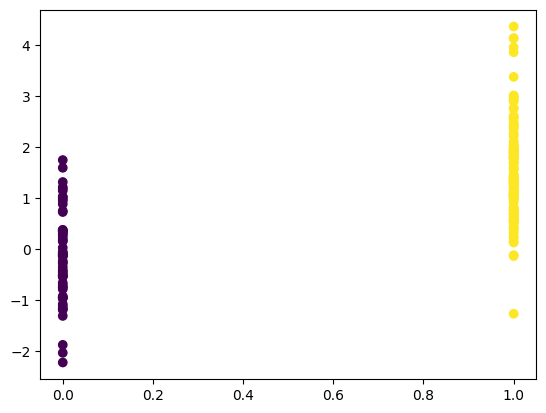

In [ ]:
N = 200
pi_true = 0.7
mu_true = 1.5
Z_true = torch.distributions.Bernoulli(pi_true).sample((N,))
X = Normal(Z_true*mu_true, 1).sample((1,)).squeeze(0)
print("Group 0 Mean:", ((1-Z_true)*X).sum()/((1-Z_true).sum()))
print("Group 1 Mean:", (Z_true*X).sum()/(Z_true.sum()))
plt.scatter(Z_true, X, c = Z_true)

Next we write functions for the three CAVI steps.

In [ ]:
def CAVI_step_pi(rho, alpha, beta):
    """
    Performs the CAVI step for pi.

    Inputs:
        rho : variational parameters for Z
        alpha, beta: hyper parameters for pi

    Outputs:
        a, b: new variational parameters for pi
    """

    return((alpha + rho.sum(), beta + (1-rho).sum()))

def CAVI_step_mu(rho, data,  eta_1, sigma_1_sq):
    """
    Performs the CAVI step for mu.

    Inputs:
        rho : variational parameters for Z
        data : the observed data X
        eta_1, sigma_1_sq : hyper parameters for pi

    Outputs:
        lamb, tau_sq: new variational parameters for mu
    """

    tau_sq_inv = 1/sigma_1_sq + rho.sum() 
    lamb = (eta_1/sigma_1_sq + (rho*data).sum())/tau_sq_inv
    return((lamb, 1/tau_sq_inv))

def CAVI_step_Z(a, b, lamb, tau_sq, data):
    """
    Performs the CAVI step for mu.

    Inputs:
        a,b : variational parameters for pi
        lamb, tau_sq : variational parameters for mu
        data : the observed data X

    Outputs:
        rho : new variational parameters for Z
    """

    digamma_ab = torch.special.digamma(torch.vstack([a,b]))
    bias = torch.vstack([X-lamb, X])
    var = torch.vstack([tau_sq, torch.zeros(1)])
    logits = digamma_ab - 0.5*(bias**2 + var)
    rho = torch.special.softmax(logits, axis =0)[0,:]

    return(rho)



We also need to track the ELBO.

In [ ]:
def ELBO(data, a, b, lamb, tau_sq, rho, alpha, beta, eta_1, sigma_1_sq): 
    beta_prior = Beta(alpha, beta)
    beta_variational = Beta(a, b)
    beta_KLD = kl_divergence(beta_variational, beta_prior)

    normal_prior = Normal(eta_1, sigma_1_sq**0.5)
    normal_variational = Normal(lamb, tau_sq**0.5)
    normal_KLD = kl_divergence(normal_variational, normal_prior)

    Z_1_term = rho*(torch.special.digamma(a) - 0.5*((data - lamb)**2 + tau_sq) - torch.log(rho))
    Z_0_term = (1-rho)*(torch.special.digamma(b) - 0.5*data**2 - torch.log(1-rho))
    
    N = data.shape[0]
    di_gammas = N*torch.special.digamma(a+b)

    return( - beta_KLD - normal_KLD + Z_1_term.sum() + Z_0_term.sum() - di_gammas )


Next we will define an algorithm that performs the CAVI iterates.

In [ ]:
def cavi(data,
         num_iter=100, 
         tol=1e-5, 
         alpha=torch.tensor([3.0]), 
         beta =torch.tensor([3.0]),
         eta_1=torch.tensor([1.0]),
         sigma_1_sq=torch.tensor([2.0]),
        ):
    """Run coordinate ascent VI for the Gaussian Mixture Model.
    
    """
    N = data.shape[0]

    # Initialize variational distributions at priors
    a = alpha
    b = beta
    lamb = eta_1
    tau_sq = sigma_1_sq

    rho = Beta(a,b).sample((N,)).squeeze(1)

    elbows = [ELBO(data, a, b, lamb, tau_sq, rho, alpha, beta, eta_1, sigma_1_sq)]
    for itr in range(num_iter):
        # Update variational factors one at a time
        a, b = CAVI_step_pi(rho, alpha, beta)
        lamb, tau_sq = CAVI_step_mu(rho, X, eta_1, sigma_1_sq)
        rho = CAVI_step_Z(a, b, lamb, tau_sq, data)
        # Compute the ELBO
        elbows.append(ELBO(data, a, b, lamb, tau_sq, rho, alpha, beta, eta_1, sigma_1_sq))
        # Check for convergence
        if elbows[-1] - elbows[-2] < -tol:
            raise Exception("ELBO is going down!")
        elif elbows[-1] - elbows[-2] < tol:
            print("Converged!")
            break

    return torch.tensor(elbows), (a, b, lamb, tau_sq, rho)
    

And now we can try it out

In [ ]:
elbows, variational_params = cavi(X, tol = 1e-4)

Converged!


We can plot the elbo to check for convergence.

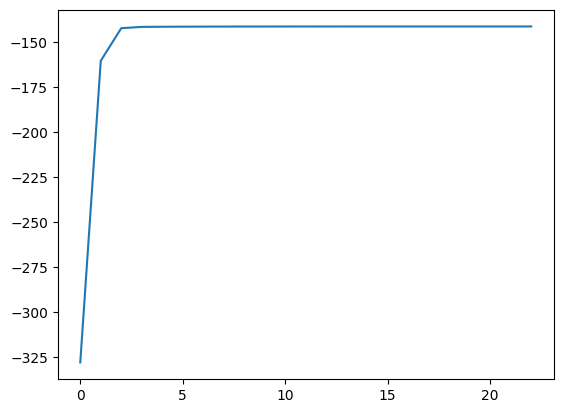

In [ ]:
plt.plot(elbows)

We can also make a scatter plot of $(\rho,X)$ colored according to the unobserved $Z$ to check our assignments.

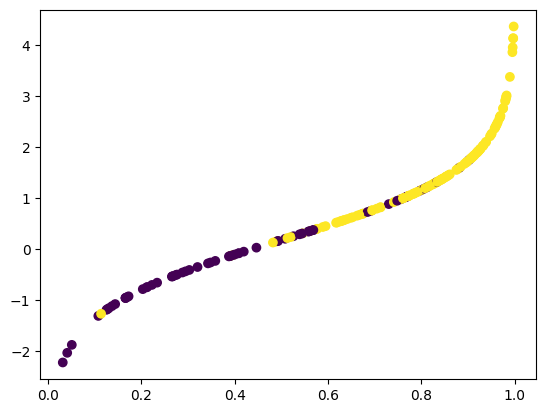

In [ ]:
a,b,lamb, tau_sq, rhos = variational_params
plt.scatter(rhos, X, c = Z_true)

We can also check if the variational mean $\lambda$ matches the true $\mu$, and is the variational expectation of $\pi$, $\frac{a}{a+b}$ matches the true value of $\pi$.

In [ ]:
print("True mu:", mu_true)
print("Variational mean of mu:", lamb)
posterior_mu = Normal(lamb, tau_sq.sqrt())
CI = posterior_mu.icdf(torch.tensor([0.025, 0.975]))
print("95% Posterior credible interval:", CI, "\n")


print("True pi:", pi_true)
print("Variational mean of pi:", a/(a+b))
CI_pi = torch.tensor([beta.ppf(0.025,a,b)[0], beta.ppf(0.975,a,b)[0]])
print("95% Posterior credible interval:", CI_pi)

True mu: 1.5
Variational mean of mu: tensor([1.4119])
95% Posterior credible interval: tensor([1.2446, 1.5792]) 

True pi: 0.7
Variational mean of pi: tensor([0.6784])
95% Posterior credible interval: tensor([0.6133, 0.7404], dtype=torch.float64)


As an exercise, you can calculate the CAVI updates for a mixture of $K$ multivariate Gaussians with spherical covariance matrices. Scott does this in this notebook [https://github.com/slinderman/stats305c/blob/spring2023/notebooks/09_cavi_gmm.ipynb](https://github.com/slinderman/stats305c/blob/spring2023/notebooks/09_cavi_gmm.ipynb)